In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# General Functions

In [2]:
def load_data_single(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    return df

def load_data_pair(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)['Close']
    return df

def backtesting(df, window):
    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change()

    # Calculate strategy returns by multiplying signal with daily returns
    df['Strategy Returns'] = df['Signal'].shift(1) * df['Returns']

    # Calculate cumulative returns
    df['Cumulative Returns'] = (1 + df['Strategy Returns']).cumprod()

    # Check if cumulative returns are positive
    if df['Cumulative Returns'].iloc[-1] > 1:
        print("Cumulative Returns are positive!")

    # Calculate key performance metrics
    cumulative_returns = df['Cumulative Returns'].iloc[-1] - 1
    returns_mean = df['Strategy Returns'].mean()
    returns_std = df['Strategy Returns'].std()
    
    # Risk-free rate not included in this calculation
    shape_ratio = (returns_mean / returns_std)

    # Calculate maximum drawdown
    rolling_max = (1 + df['Strategy Returns']).cumprod().rolling(window=window, min_periods=1).max()
    daily_drawdown = (1 + df['Strategy Returns']).cumprod() / rolling_max - 1
    max_drawdown = daily_drawdown.min()

    # Print the results
    print(f"Cumulative Returns: {cumulative_returns * 100:.2f}%")
    print(f"Returns Mean: {returns_mean * 100:.2f}%")
    print(f"Returns Standard Deviation: {returns_std * 100:.2f}%")
    print(f"Sharpe Ratio: {shape_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

    # Plot Cumulative Returns
    plt.figure(figsize=(12, 6))
    plt.plot(df.index.to_numpy(), df['Cumulative Returns'].to_numpy(), label='Cumulative Returns', color='green', linewidth=2)
    plt.axhline(y=1, color='black', linestyle='--', label='Initial Investment')
    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Strategies
## Bollinger Bands 

In [3]:
def generate_signals_bollinger_bands(df, window, stdev):
    # Calculate the rolling mean and standard deviation
    df['SMA'] = df['Close'].rolling(window=window).mean()
    df['Upper'] = df['SMA'] + (stdev * df['Close'].rolling(window=window).std())
    df['Lower'] = df['SMA'] - (stdev * df['Close'].rolling(window=window).std())
    
    # Initialize with no signal
    df['Signal'] = 0

    # Buy signal: Price touches or crosses below the lower band
    df.loc[df['Close'] <= df['Lower'], 'Signal'] = 1

    # Sell signal: Price touches or crosses above the upper band
    df.loc[df['Close'] >= df['Upper'], 'Signal'] = -1
    
    return df

def visualization_bollinger_bands(df):
    # Plot the price data and Bollinger Bands along with Cumulative Returns
    plt.figure(figsize=(12, 6))
    plt.plot(df['Close'], label='Price')
    plt.plot(df['SMA'], label='SMA', linestyle='--')
    plt.plot(df['Upper'], label='Upper Band', linestyle='--')
    plt.plot(df['Lower'], label='Lower Band', linestyle='--')
    plt.title('Bollinger Bands Trading Strategy Visualization')
    plt.legend()
    plt.show()
    
def bollinger_bands(ticker, start_date, end_date, window, stdev):
    df = load_data_single(ticker, start_date, end_date)
    df = generate_signals_bollinger_bands(df, window, stdev)
    visualization_bollinger_bands(df)
    backtesting(df, window)

### Stock example - DAL

[*********************100%***********************]  1 of 1 completed


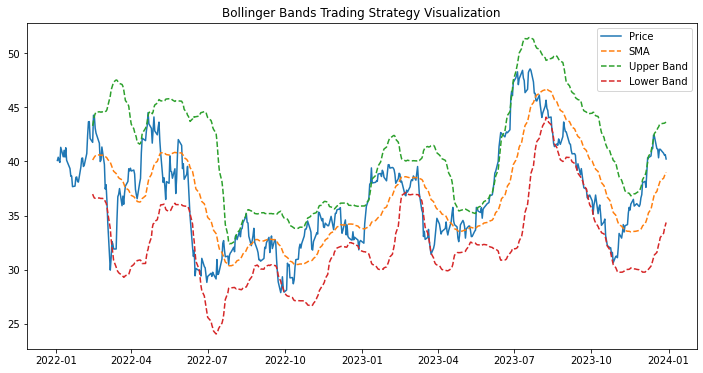

Cumulative Returns: -33.70%
Returns Mean: -0.08%
Returns Standard Deviation: 1.04%
Sharpe Ratio: -0.07
Maximum Drawdown: -15.77%


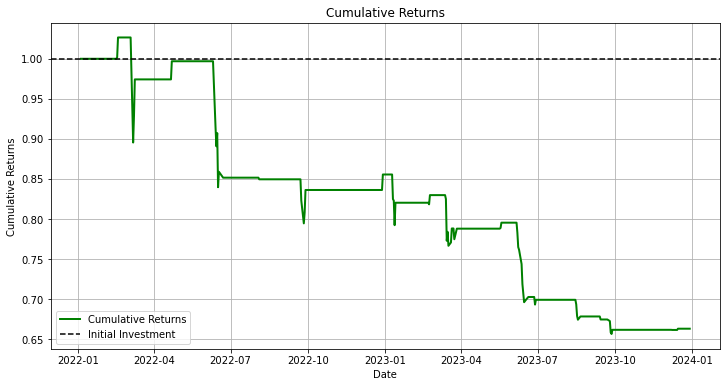

In [4]:
bollinger_bands(ticker='DAL', 
                start_date='2022-01-01', 
                end_date='2023-12-31', 
                window=30, 
                stdev=2)

### Stock example - AAL

[*********************100%***********************]  1 of 1 completed


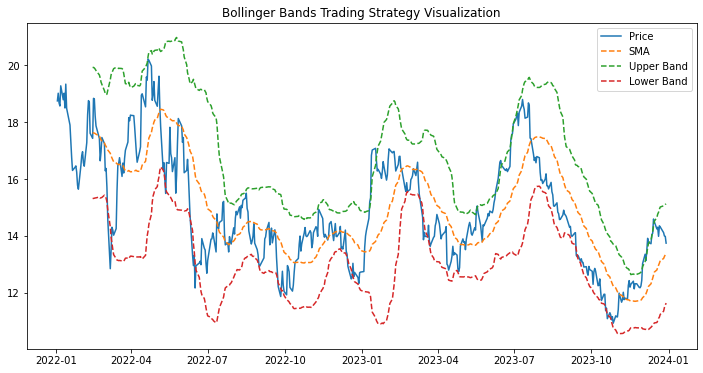

Cumulative Returns: -18.01%
Returns Mean: -0.03%
Returns Standard Deviation: 1.13%
Sharpe Ratio: -0.03
Maximum Drawdown: -11.99%


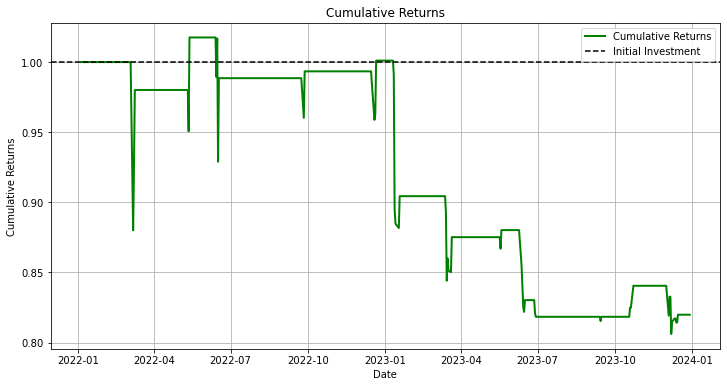

In [5]:
bollinger_bands(ticker='AAL', 
                start_date='2022-01-01', 
                end_date='2023-12-31', 
                window=30, 
                stdev=2)

## Mean Reversion

In [6]:
def visualize_pair(df):
    df.index = pd.to_datetime(df.index)
    df.plot(figsize=(10, 5))
    plt.ylabel('Prices')
    plt.xlabel('Date')
    plt.title('Pair Price Series Visualization')
    plt.show()

# Check for cointegration
def stationarity(df, cutoff='5%'):
    # Calculate ratio
    df = df.dropna()
    model = sm.OLS(df.iloc[:, 0], df.iloc[:, 1]).fit()
    hedge_ratio = model.params[0]
    df['spread'] = df.iloc[:, 0] - hedge_ratio * df.iloc[:, 0]
    
    adf = adfuller(df['spread'], maxlag = 1)
    test_stat = adf[0] 
    t_stat = adf[4][cutoff]
    
    if test_stat < t_stat:
        return True
    else: 
        return False
    
def generate_signals_mean_reversion(df, window, stdev):
    df['Close'] = df.iloc[:, 0] / df.iloc[:, 1]
    
    # Compute rolling mean of ratio
    roll_avg_column_name = 'roll_avg_' + str(window)
    df[roll_avg_column_name] = df['Close'].rolling(window=window).mean()

    # Compute rolling standard deviation of ratio
    roll_std_column_name = 'roll_std_' + str(window)
    df[roll_std_column_name] = df['Close'].rolling(window=window).std()

    # Calculate z-score
    z_score = (df['Close'] - df[roll_avg_column_name]) / df[roll_std_column_name]

    # Plot z-score
    plt.figure(figsize=(10, 5))
    z_score.plot()
    plt.axhline(0, color='black')
    plt.axhline(2.0, color='red', linestyle='--')
    plt.axhline(-2.0, color='green', linestyle='--')
    plt.legend(['Z-Score', 'Mean', '+2', '-2'])
    plt.ylabel('Standard Deviation')
    plt.title('Z-Score Plot')
    plt.show()
    
    # Define entry and exit points
    # Long entry
    long_positions = np.where(z_score < -stdev, 1, 0)

    # Long exit
    long_positions = np.where(z_score >= 0, 0, long_positions)

    # Short entry
    short_positions = np.where(z_score > stdev, 1, 0)

    # Short exit
    short_positions = np.where(z_score <= 0, 0, short_positions)

    # Combine the positions
    df['Signal'] = long_positions + short_positions

    # Fill NaN values
    df = df.fillna(method='ffill')
    
    return df

def mean_reversion(ticker_list, start_date, end_date, cutoff_alpha, window, stdev):
    df = load_data_pair(ticker_list, start_date, end_date)
    visualize_pair(df)
    if stationarity(df, cutoff_alpha):
        df = generate_signals_mean_reversion(df, window, stdev)
        backtesting(df, window)

### Stock example - DAL & AAL

[*********************100%***********************]  2 of 2 completed


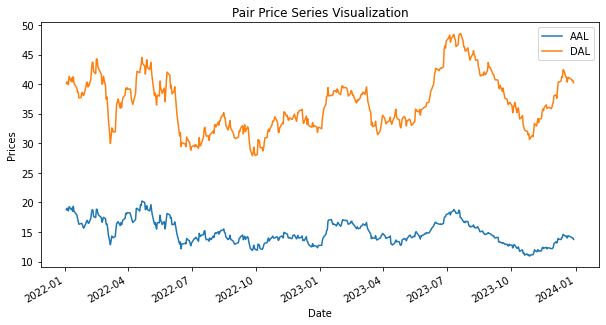

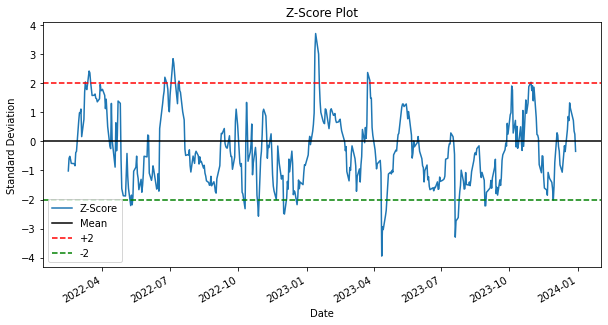

Cumulative Returns are positive!
Cumulative Returns: 6.52%
Returns Mean: 0.01%
Returns Standard Deviation: 0.41%
Sharpe Ratio: 0.03
Maximum Drawdown: -3.37%


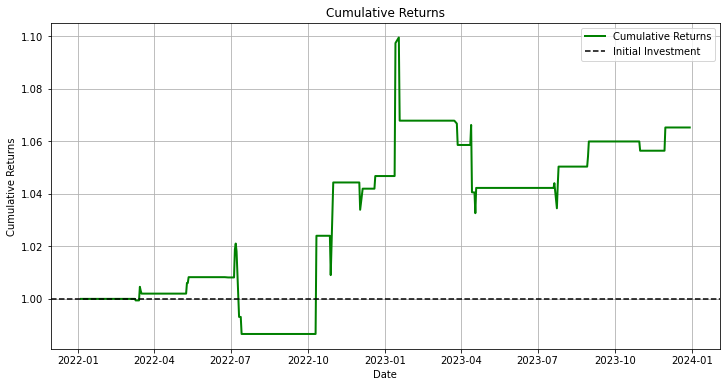

In [7]:
mean_reversion(ticker_list=['DAL', 'AAL'], 
               start_date='2022-01-01', 
               end_date='2023-12-31', 
               cutoff_alpha='5%', 
               window=30, 
               stdev=2)

## Mean Reversion with Bollinger Bands
Crossing the lower band from below:
* IF spread(t-1) < lower band(t-1) AND spread(t) > lower band(t), Go long.

Crossing the upper band from above:
* IF spread(t-1) > upper band(t-1) AND spread(t) < upper band(t), Go short.

Main idea:
* If the spread reaches the mean of the band after taking a long/short position, we will square off the position.
* If the spread crosses out of the band again after taking a long/short position, we consider that as the stop loss and the position is squared off.

In [8]:
def visualize_pair(df):
    df.index = pd.to_datetime(df.index)
    df.plot(figsize=(10, 5))
    plt.ylabel('Prices')
    plt.xlabel('Date')
    plt.title('Pair Price Series Visualization')
    plt.show()

# Check for cointegration
def stationarity(df, cutoff='5%'):
    # Calculate ratio
    df = df.dropna()
    model = sm.OLS(df.iloc[:, 0], df.iloc[:, 1]).fit()
    hedge_ratio = model.params[0]
    df['spread'] = df.iloc[:, 0] - hedge_ratio * df.iloc[:, 0]
    
    adf = adfuller(df['spread'], maxlag = 1)
    test_stat = adf[0] 
    t_stat = adf[4][cutoff]
    print("The ADF test statistic is:", test_stat)
    print("The t-test statistic is:", t_stat)
    
    if test_stat < t_stat:
        print('The spread of the pair is stationary :)\n')
        return True
    else: 
        print('The spread of the pair is NOT stationary!\n')
        return False
    
def generate_signals_mean_reversion_w_bollinger(df, window, stdev):
    model = sm.OLS(df.iloc[:, 0], df.iloc[:, 1]).fit()
    hedge_ratio = model.params[0]
    df['spread'] = df.iloc[:, 0] - hedge_ratio * df.iloc[:, 0]
    
    df['mean'] = df['spread'].rolling(window=window).mean()
    df['stdev'] = df['spread'].rolling(window=window).std()
    df['upper_band'] = df['mean'] + (stdev * df['stdev'])
    df['lower_band'] = df['mean'] - (stdev * df['stdev'])
    
    # Signal Calculation
    # Create a condition for the buy signal
    buy_condition = (df['spread'].shift(1) < df['lower_band'].shift(1)) & (df['spread'] > df['lower_band'])

    # Create a condition for the sell signal
    sell_condition = (df['spread'].shift(1) > df['upper_band'].shift(1)) & (df['spread'] < df['upper_band'])

    # Initialize 'signal' column with 0
    df['signal'] = 0

    # Set 'signal' column values based on conditions
    df.loc[buy_condition, 'signal'] = 1
    df.loc[sell_condition, 'signal'] = -1
    
    df = calculate_status(df)
    df = calculate_trade_quantity(df, hedge_ratio)
    df = calculate_traded_value(df)
    df = calculate_returns(df)
    
    return df

def calculate_status(df):
    # If the current position is that of a long/short position in a trade,
    # it will keep checking at every closing whether the stop loss/target was hit or not.
    # If the stop loss/target is hit, 
    # the function will close the position and look for a new possible trade
    
    status = []
    
    for i in range(len(df)):
        if i == 0:
            status.append(df['signal'][i])
        elif (status[i-1] in [0, 'TP', 'SL']):
            status.append(df['signal'][i])
        else:
            if status[i-1] == 1:
                stop_loss_price = df.at[df.index[i], 'lower_band']
                take_profit_price = df.at[df.index[i], 'mean']
                spread = df.at[df.index[i], 'spread']
                if spread <= stop_loss_price:
                    status.append('SL')
                elif spread >= take_profit_price:
                    status.append('TP')
                else:
                    status.append(status[i-1])
            elif status[i-1] == -1:
                stop_loss_price = df.at[df.index[i], 'upper_band']
                take_profit_price = df.at[df.index[i], 'mean']
                spread = df.at[df.index[i], 'spread']
                if spread >= stop_loss_price:
                    status.append('SL')
                elif spread <= take_profit_price:
                    status.append('TP')
                else:
                    status.append(status[i-1])

    df['status'] = status
    
    return df

def calculate_trade_quantity(df, hedge_ratio):
    # Calculate the quantity to trade for stock #1 and stock #2 based on hedge ratio
    stock1_qty = np.where(df['signal'] == 1, 1000, -1000)
    stock2_qty = stock1_qty * round(hedge_ratio, 3) * -1

    # Set quantity to 0 for 'TP' and 'SL' signals
    stock1_qty[df['signal'].isin(['TP', 'SL'])] = 0
    stock2_qty[df['signal'].isin(['TP', 'SL'])] = 0

    # Create new columns in the DataFrame
    df['stock1_qty'] = stock1_qty
    df['stock2_qty'] = stock2_qty
    
    return df

def calculate_traded_value(df):
    pair = df.columns[:2]
    df['Stock 1 Trade Price'] = np.where(df['status'] != 0, df[pair[0]], 0)
    df['Stock 2 Trade Price'] = np.where(df['status'] != 0, df[pair[1]], 0)
    df['stock1_traded_value'] = df['stock1_qty'] * df['Stock 1 Trade Price']
    df['stock2_traded_value'] = df['stock2_qty'] * df['Stock 2 Trade Price']
    
    return df

def calculate_returns(df):
    df['stock1_return'] = 0
    df['stock2_return'] = 0
    
    for i in range(1, len(df)): 
        if df.at[df.index[i-1], 'status'] == 1:
            # Return on stock 1 = (Traded Value at t / Traded Value at (t-1))-1
            df.at[df.index[i], 'stock1_return'] = (df.at[df.index[i], 'stock1_traded_value'] / df.at[df.index[i-1], 'stock1_traded_value']) - 1
        elif df.at[df.index[i-1], 'status'] == -1:
            # Return on stock 1 = 1-(Traded Value at t / Traded Value at (t-1))
            df.at[df.index[i], 'stock1_return'] = 1 - (df.at[df.index[i], 'stock1_traded_value'] / df.at[df.index[i-1], 'stock1_traded_value'])

        if df.at[df.index[i-1], 'status'] == 1:
            # Return on stock 2 = 1-(Traded Value at t / Traded Value at (t-1))
            df.at[df.index[i], 'stock2_return'] = 1 - (df.at[df.index[i], 'stock2_traded_value'] / df.at[df.index[i-1], 'stock2_traded_value'])
        elif df.at[df.index[i-1], 'status'] == -1:
            # Return on stock 2 = (Traded Value at t / Traded Value at (t-1))-1
            df.at[df.index[i], 'stock2_return'] = (df.at[df.index[i], 'stock2_traded_value'] / df.at[df.index[i-1], 'stock2_traded_value']) - 1

    df['total_returns'] = df['stock1_return'] + df['stock2_return']
    
    return df

def generate_metrics(df, window):
    # Calculate cumulative returns
    df['Cumulative Returns'] = (1 + df['total_returns']).cumprod()

    # Check if cumulative returns are positive
    if df['Cumulative Returns'].iloc[-1] > 1:
        print("Cumulative Returns are positive!")

    # Calculate key performance metrics
    cumulative_returns = df['Cumulative Returns'].iloc[-1] - 1
    returns_mean = df['total_returns'].mean()
    returns_std = df['total_returns'].std()
    shape_ratio = (returns_mean / returns_std) # Risk-free rate not included in this calculation

    # Calculate maximum drawdown
    rolling_max = (1 + df['total_returns']).cumprod().rolling(window=window, min_periods=1).max()
    daily_drawdown = (1 + df['total_returns']).cumprod() / rolling_max - 1
    max_drawdown = daily_drawdown.min()

    # Print the results
    print(f"Cumulative Returns: {cumulative_returns * 100:.2f}%")
    print(f"Returns Mean: {returns_mean * 100:.2f}%")
    print(f"Returns Standard Deviation: {returns_std * 100:.2f}%")
    print(f"Sharpe Ratio: {shape_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
    
    return df

def visualize_returns(df):
    # Plot Cumulative Returns
    plt.figure(figsize=(12, 6))
    plt.plot(df.index.to_numpy(), df['Cumulative Returns'].to_numpy(), label='Cumulative Returns', color='green', linewidth=2)
    plt.axhline(y=1, color='black', linestyle='--', label='Initial Investment')
    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Method function for a single pair with visualizations
def mean_reversion_w_bollinger(ticker_list, start_date, end_date, cutoff, window, stdev):
    df = load_data_pair(ticker_list, start_date, end_date)
    visualize_pair(df)
    if stationarity(df, cutoff):
        df = generate_signals_mean_reversion_w_bollinger(df, window, stdev)
        df = generate_metrics(df, window)
        visualize_returns(df)

### Stock example - DAL & AAL

[*********************100%***********************]  2 of 2 completed


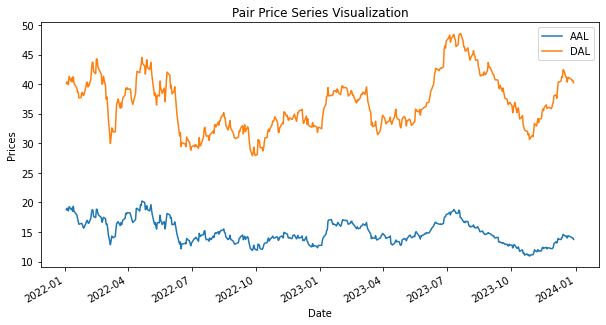

The ADF test statistic is: -3.0463181949260854
The t-test statistic is: -2.867349510566146
The spread of the pair is stationary :)

Cumulative Returns are positive!
Cumulative Returns: 31.59%
Returns Mean: 0.06%
Returns Standard Deviation: 0.81%
Sharpe Ratio: 0.07
Maximum Drawdown: -13.39%


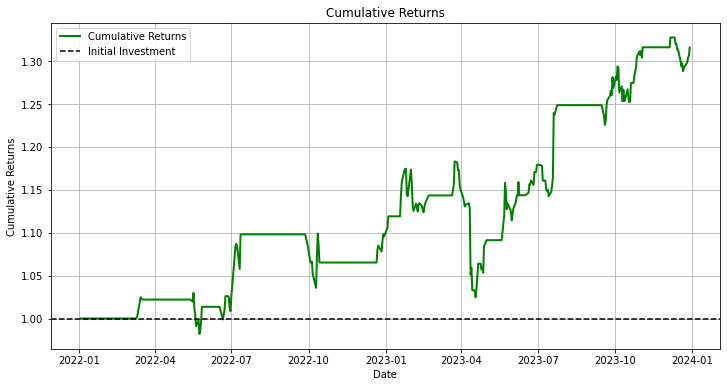

In [9]:
mean_reversion_w_bollinger(ticker_list=['DAL', 'AAL'], 
                           start_date='2022-01-01', 
                           end_date='2023-12-31', 
                           cutoff='5%', 
                           window=30, 
                           stdev=2)

### Stock example - WMB & KMI

[*********************100%***********************]  2 of 2 completed


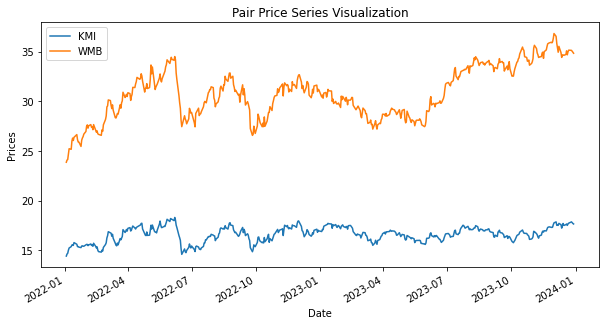

The ADF test statistic is: -4.141342591914697
The t-test statistic is: -2.867349510566146
The spread of the pair is stationary :)

Cumulative Returns are positive!
Cumulative Returns: 1.89%
Returns Mean: 0.00%
Returns Standard Deviation: 0.43%
Sharpe Ratio: 0.01
Maximum Drawdown: -7.95%


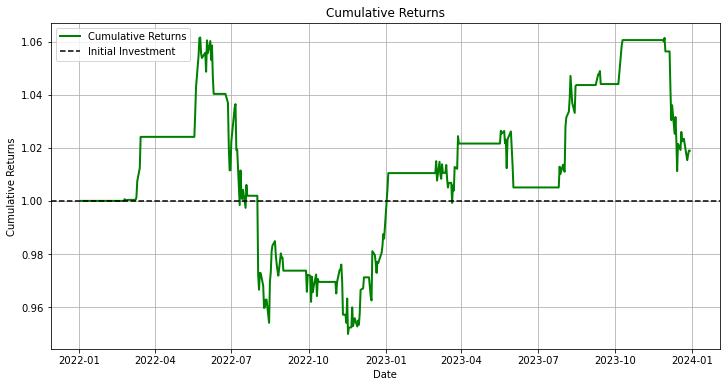

In [10]:
mean_reversion_w_bollinger(ticker_list=['WMB', 'KMI'], 
                           start_date='2022-01-01', 
                           end_date='2023-12-31', 
                           cutoff='5%', 
                           window=30, 
                           stdev=2)

## Check Mean Reversion with Bollinger Bands in Batch
* Take in a list of ticker pairs and generate a csv file containing the stocks passing the ADF tests as well as their performance metrics with the mean reversion + bollinger bands strategy.

In [11]:
def check_mean_reversion_w_bollinger_in_batch(ticker_pair_list, start_date, end_date, cutoff, window, stdev):
    results = pd.DataFrame(columns=['pair', 'cumulative_return', 'mean_return',
                                    'stdev_return', 'sharpe_ratio', 'max_drawdown'])
    for pair in ticker_pair_list:
        df = load_data_pair(pair, start_date, end_date)
        
        if stationarity(df, cutoff):
            df = generate_signals_mean_reversion_w_bollinger(df, window, stdev)
            
            # Calculate cumulative returns
            df['Cumulative Returns'] = (1 + df['total_returns']).cumprod()

            # Check if cumulative returns are positive
            if df['Cumulative Returns'].iloc[-1] > 1:
                print("Cumulative Returns are positive!")

            # Calculate key performance metrics
            cumulative_returns = df['Cumulative Returns'].iloc[-1] - 1
            returns_mean = df['total_returns'].mean()
            returns_std = df['total_returns'].std()
            
            # Risk-free rate not included in this calculation
            sharpe_ratio = (returns_mean / returns_std)

            # Calculate maximum drawdown
            rolling_max = (1 + df['total_returns']).cumprod().rolling(window=window, min_periods=1).max()
            daily_drawdown = (1 + df['total_returns']).cumprod() / rolling_max - 1
            max_drawdown = daily_drawdown.min()
            
            results.loc[len(results)] = [pair, cumulative_returns, returns_mean,
                                         returns_std, sharpe_ratio, max_drawdown]
    
    results.to_csv('pair_check_result.csv', index=False)

### Stock example

In [12]:
ticker_pair_list = [['MMC', 'AON'], ['WTFC', 'ONB'], ['HBAN', 'USB'], ['PLAY', 'SHAK'],
                    ['DAL', 'AAL'], ['BR', 'FDS'], ['FRT', 'KIM'], ['CVS', 'WBA'],
                    ['WMB', 'KMI'], ['CACI', 'BAH'], ['FANG', 'CTRA'], ['JBL', 'FLEX'],
                    ['PSTG', 'NTNX'], ['LSTR', 'CHRW'], ['DG', 'DLTR'], ['CUBE', 'PSA'],
                    ['AMH', 'MAA'], ['FIS', 'JKH']]

check_mean_reversion_w_bollinger_in_batch(
    ticker_pair_list=ticker_pair_list, 
    start_date='2021-01-01', 
    end_date='2023-12-31',
    cutoff='5%', 
    window=30, 
    stdev=2
)

[*********************100%***********************]  2 of 2 completed
The ADF test statistic is: -2.5545584107918597
The t-test statistic is: -2.8653910653234655
The spread of the pair is NOT stationary!

[*********************100%***********************]  2 of 2 completed
The ADF test statistic is: -2.53394984605477
The t-test statistic is: -2.8653910653234655
The spread of the pair is NOT stationary!

[*********************100%***********************]  2 of 2 completed
The ADF test statistic is: -2.583928564371277
The t-test statistic is: -2.8653910653234655
The spread of the pair is NOT stationary!

[*********************100%***********************]  2 of 2 completed
The ADF test statistic is: -3.7180398489502533
The t-test statistic is: -2.8653910653234655
The spread of the pair is stationary :)

[*********************100%***********************]  2 of 2 completed
The ADF test statistic is: -1.9967271214055007
The t-test statistic is: -2.8653910653234655
The spread of the pair is NO

In [13]:
pd.read_csv('pair_check_result.csv')

,pair,cumulative_return,mean_return,stdev_return,sharpe_ratio,max_drawdown
0,"['PLAY', 'SHAK']",-0.452038,-0.000551,0.022232,-0.024798,-0.270240
1,"['FRT', 'KIM']",-0.054402,-0.000057,0.005917,-0.009598,-0.087318
2,"['WMB', 'KMI']",0.166156,0.000218,0.005207,0.041801,-0.103872
3,"['LSTR', 'CHRW']",0.011336,0.000055,0.009019,0.006148,-0.147481


# Conclusion
* With the strategy of bollinger bands only, we are achieving negative cumulative returns respectively for the stocks "AAL" and "DAL".
* With the strategy of mean reversion only, we are achieving moderately positive cumulative returns for the stock pair "AAL" and "DAL".
* With the strategy of mean reversion with bollinger bands, we are achieving significantly positive cumulative returns for the stock pair "AAL" and "DAL".
* With the batch search function leveraging mean reversion and bollinger bands, we can quickly select appropriate pair for the strategy and get associated performance metrics for evaluation analysis.